# Deep Learning for Audio Signals

### Training a CNN on MFCC features generated from Genre music files

Rajesh Siraskar | 04-May-2021

- Load data
- Create train/validation/test sets (unseen)
- Build CNN network architecture
- Compile network
- Train network
- Evaluate
- Make predictions on a sample

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
%matplotlib inline

In [2]:
JSON_DATA_FILE = "audio_files/mfcc_json.json"
NUMBER_OF_CLASSES = 4 # Reduced set has only 4 genres

### Load data

In [3]:
def load_data(json_file):
    with open(json_file, "r") as fp:
        data = json.load(fp)
        
        # Note: mfcc was converted from a numpy array to list before storing in JSON
        #  Need convert back to numpy array
        X = np.array(data["mfcc"])
        y = np.array(data["labels"])
        
    return X, y

### 1. Create train/validation/test sets (unseen)
--------------------------------------------------------

#### Note: CNN expects a 3-D array.
    - Our data was saved with the following parameters
    - num_mfcc=13; num_segments=10; num_mfcc_vectors_per_segment: 130
    - X.data.shape:  (80, 130, 13)
    - y.data.shape:  (80,)
    
    - X.data.shape: dim-1: No of samples = 4 classes * 2 .wav files per genre * 10 segments = 80, 
    -               dim-2: time-bins = 130, 
    -               dim-3: mfcc-features = 13)

### For CNN we need to add an additional channel: 
    - Loaded X is (80, 130, 1)
    - For CNN, X needs to be (130, 13, 1)
    - The 3rd dim is the CHANNEL so will be 1
    - So X becomes actually a 4D arraay with the added channel dim

In [4]:
def prepare_datasets(test_size=0.25, validation_size=0.2):
    # load data
    X, y = load_data(JSON_DATA_FILE)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # create train/validation set
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                    test_size=validation_size)
    
    # CNN expects a 3-D array
    # -----------------------
    # Our data was saved with the following parameters
    #    num_mfcc=13; num_segments=10; num_mfcc_vectors_per_segment: 130
    # X.data.shape: dim-1: No of samples = 4 classes * 2 .wav files per genre * 10 segments = 80, 
    #               dim-2: time-bins = 130, 
    #               dim-3: mfcc-features = 13)
    # y.data.shape:  (80,)
    #
    #
    # For CNN we need to add an additional channel: 
    # - Loaded X is (80, 130, 1)
    # - For CNN, X needs to be (130, 13, 1)
    # - The 3rd dim is the CHANNEL so will be 1
    # - So X becomes actually a 4D arraay with the added channel dim
    
    # Create the 3-D array for X_train, but first add newaxis for channel
    X_train = X_train [..., np.newaxis]           # 4D array = [num_sample, 130, 13, 1]
    X_validation = X_validation [..., np.newaxis] # -- "" --
    X_test = X_test [..., np.newaxis]             # -- "" --
    
    # Return the 4-D data
    return  X_train, X_validation, X_test, y_train, y_validation, y_test

### 2. Build the CNN network

In [5]:
def build_model(input_shape):
    
    # Ceate model
    model = keras.Sequential()
    # 1st conv. layer (along with max-pooling,normalize output - which speeds up training)
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())              
    
    # 2nd. conv. layer - same as above. Note input shape remains same
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                                  input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())                      
    
    # 3rd. conv. layer - same as above but reduce filter sizes (both kernel and pooling)
    # Again, note, input shape remains same
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 
    
    # Flatten the output and feed to a dense layer, also add dropout to reduce over-fitting
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Final output layer with softmax) for classification
    # Neurons = number of classes i.e. genres = NUMBER_OF_CLASSES
    model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
    
    return model

### Utility functions: 
1. Plot accuracy/loss curves
2. Load JSON data file and return genre names

In [44]:
def plot_history (history, regularization_flag=False):

    fig, axs = plt.subplots(2, figsize=(12, 8)) # width, height
    
    # Accuracy sub-plot
    axs[0].plot(history.history["accuracy"], label="Training accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_facecolor('#FFFFF0') # little darker biege: #F5F5DC
    if regularization_flag: axs[0].set_title("Accuracy plot (with regularizatiton)")
    else: axs[0].set_title("Accuracy plot")
    
    # Error (loss) sub-plot
    axs[1].plot(history.history["loss"], label="Training error")
    axs[1].plot(history.history["val_loss"], label="Test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epochs")   
    axs[1].legend(loc="upper right")
    axs[1].set_facecolor('#FFFFF0')
    if regularization_flag: axs[1].set_title("Error plot (with regularizatiton)")
    else: axs[1].set_title("Error plot")
    

    plt.show()
    
def load_mappings(json_file):
    with open(json_file, "r") as fp:
        data = json.load(fp)
        
        # Note: mfcc was converted from a numpy array to list before storing in JSON
        #  Need convert back to numpy array
        genre_mapping = np.array(data["mapping"])
        
    return genre_mapping

### Main function
1. Create train/validation/test sets (unseen)
2. Build the CNN network
3. Compile the network
4. Train the model
5. Evaluate the model on unseen test set
6. Predict on a sample

In [45]:
## 1. Create train/validation/test sets (unseen)
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(test_size=0.25, 
                                                                                validation_size=0.2)
## 2. Build the CNN network
#  X_train is a 4-D array. For input shape, take the 3-dims from dimension 2 onwards. 
#  The 1st dim was num_samples and is not considered as it will be part of training samples
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

## 3. Compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 4. Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_validation, y_validation), 
                    batch_size=32, 
                    epochs=200) # 30 epochs accuracy=0.70; 400 epochs=0.95

## 5. Evaluate the model on unseen test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1) 
print("\n\n - Accuracy on un-seen test set: {0:.3f}".format(test_accuracy))

Epoch 1/200
2/2 [==============================] - 1s 262ms/step - loss: 2.1222 - accuracy: 0.2535 - val_loss: 3.5711 - val_accuracy: 0.3333
Epoch 2/200
2/2 [==============================] - 0s 61ms/step - loss: 1.9506 - accuracy: 0.2812 - val_loss: 3.0337 - val_accuracy: 0.3333
Epoch 3/200
2/2 [==============================] - 0s 57ms/step - loss: 2.0564 - accuracy: 0.2847 - val_loss: 2.7043 - val_accuracy: 0.3333
Epoch 4/200
2/2 [==============================] - 0s 63ms/step - loss: 1.7694 - accuracy: 0.3438 - val_loss: 2.4683 - val_accuracy: 0.3333
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 1.6699 - accuracy: 0.3299 - val_loss: 2.2588 - val_accuracy: 0.3333
Epoch 6/200
2/2 [==============================] - 0s 60ms/step - loss: 1.4992 - accuracy: 0.3611 - val_loss: 2.0873 - val_accuracy: 0.3333
Epoch 7/200
2/2 [==============================] - 0s 61ms/step - loss: 1.2910 - accuracy: 0.3819 - val_loss: 1.9449 - val_accuracy: 0.3333
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 61ms/step - loss: 0.1068 - accuracy: 1.0000 - val_loss: 0.8326 - val_accuracy: 0.5833
Epoch 60/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1000 - accuracy: 1.0000 - val_loss: 0.8276 - val_accuracy: 0.6667
Epoch 61/200
2/2 [==============================] - 0s 56ms/step - loss: 0.1082 - accuracy: 0.9757 - val_loss: 0.8227 - val_accuracy: 0.6667
Epoch 62/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.8172 - val_accuracy: 0.6667
Epoch 63/200
2/2 [==============================] - 0s 61ms/step - loss: 0.0827 - accuracy: 1.0000 - val_loss: 0.8117 - val_accuracy: 0.6667
Epoch 64/200
2/2 [==============================] - 0s 61ms/step - loss: 0.0978 - accuracy: 1.0000 - val_loss: 0.8066 - val_accuracy: 0.6667
Epoch 65/200
2/2 [==============================] - 0s 59ms/step - loss: 0.0733 - accuracy: 1.0000 - val_loss: 0.8003 - val_accuracy: 0.6667
Epoch 66/200
2/2 [========

2/2 [==============================] - 0s 63ms/step - loss: 0.0445 - accuracy: 1.0000 - val_loss: 0.5448 - val_accuracy: 0.8333
Epoch 118/200
2/2 [==============================] - 0s 56ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.5432 - val_accuracy: 0.8333
Epoch 119/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.5400 - val_accuracy: 0.8333
Epoch 120/200
2/2 [==============================] - 0s 56ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.5376 - val_accuracy: 0.8333
Epoch 121/200
2/2 [==============================] - 0s 55ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.5353 - val_accuracy: 0.8333
Epoch 122/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0294 - accuracy: 1.0000 - val_loss: 0.5329 - val_accuracy: 0.8333
Epoch 123/200
2/2 [==============================] - 0s 59ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.5307 - val_accuracy: 0.8333
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.4350 - val_accuracy: 0.8333
Epoch 176/200
2/2 [==============================] - 0s 55ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.4339 - val_accuracy: 0.8333
Epoch 177/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.4334 - val_accuracy: 0.8333
Epoch 178/200
2/2 [==============================] - 0s 56ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.4327 - val_accuracy: 0.8333
Epoch 179/200
2/2 [==============================] - 0s 55ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.4324 - val_accuracy: 0.8333
Epoch 180/200
2/2 [==============================] - 0s 55ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.4291 - val_accuracy: 0.8333
Epoch 181/200
2/2 [==============================] - 0s 54ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.4265 - val_accuracy: 0.8333
Epoch 

In [46]:
## 5. Evaluate the model on unseen test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=0) 
print("- Accuracy on un-seen test set: {0:.3f}".format(test_accuracy))

- Accuracy on un-seen test set: 0.900


In [52]:
def predict(model, X, y):
    
    # For prediction we need 4 D so need to add the sample number as 1st dim.
    # X -> (1, 130, 13, 1) where the 1st dim is the sample size = 1
    X = X[np.newaxis, ...]
    
    # Get "predictions", which is an array of probablities [[0.37, 0.11, 0.87, ...]]
    prediction = model.predict(X)
    
    # Extract index with max. value
    predicted_index = np.argmax(prediction, axis=1)

    # Get semantaic labels (i.e. text genre labels)
    mapping = load_mappings(JSON_DATA_FILE)
    
    # Map indexes to genre labels
    expected_genre_label = mapping[y]
    predicted_genre_label = mapping[predicted_index][0]
    
    print("Expected genre: '{}'. Predicted genre: '{}'".format(expected_genre_label, predicted_genre_label))
    

In [53]:
import random

## 6. Predict
sample = random.randint(0,19) # Total 20 samples, so select any sample 1-20
X = X_test[sample] 
y = y_test[sample]

predict(model, X, y)

Expected genre: 'classical'. Predicted genre: 'classical'


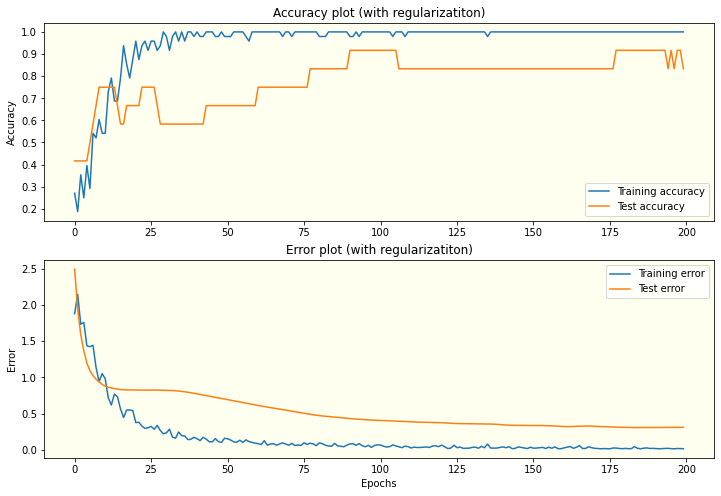

In [11]:
## 7. Plot training curves - NO regularization
plot_history(history, regularization_flag=True)